# Calculating tides for Washington DC<br/>Combining UTide and NOAA Tides and Currents data
The Python implementation of UTide can be found here: https://github.com/wesleybowman/UTide <br/>
it is based on the Matlab UTide library described by D.L. Codiga (2011): ftp://www.po.gso.uri.edu/pub/downloads/codiga/pubs/2011Codiga-UTide-Report.pdf

## Import modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt, mpld3
mpld3.enable_notebook()
from matplotlib import style
from matplotlib.dates import date2num
style.use('seaborn-notebook')

import utide
from utide import solve, reconstruct

from datetime import datetime as dt
from datetime import timedelta
import pandas as pd

In [2]:
print(utide.__version__)

0.1.0


## Import Tides and Currents data

In [3]:
obs = pd.read_table(r"C:\Users\jdorvinen\Documents\GitHub\hydro-notebooks\tides\data\8594900_hourly_height_combined.txt",
                   names= ['datetime', 'elev', 'sigma', 'i', 'l'],
                   skiprows=1,
                   index_col='datetime',
                   usecols=[0,1],
                   delimiter=',')
obs.index = obs.index.astype('datetime64[ns]')
#obs.head(6)

### Make relative to MSL

In [4]:
obs['anomaly'] = obs['elev'] - obs['elev'].mean()
obs['anomaly'] = obs['anomaly'].interpolate()

## Calculate tidal constituents

In [5]:
time = date2num(obs.index.to_pydatetime())

coef = solve(time, obs['anomaly'].values,
              lat=38.8733,
              method='ols',
              conf_int='linear')

solve: matrix prep ... solution ... diagnostics ... done.


### Save yourself some time and pickle coef for future use

In [9]:
import pickle
# Pickle the coef dictionary
with open(r"P:\Temp\Dorvinen\utides\coef_8594900.pkl", 'wb') as output:
    # Pickle coef dictionary using protocol 0.
    pickle.dump(coef, output)
# Unpickle the coef dictionary
with open(r"P:\Temp\Dorvinen\utides\coef_8594900.pkl", 'rb') as pkl_file:
    coef2 = pickle.load(pkl_file)

Make sure they're the same

In [13]:
hash(frozenset(coef)) == hash(frozenset(coef2))

True

## Construct future tides using calculated coef

Create hourly series of datetimes into the future

In [17]:
future_days = 3
GMT2EST = -4 # -4=EDT, -5=EST
base = dt.today()
base = dt(*base.timetuple()[:3])
futuredaysGMT = [base + timedelta(minutes=x) for x in range(0-(GMT2EST*60), (future_days*24*60)-(GMT2EST*60))]
futuredaysLST = [base + timedelta(minutes=x) for x in range(0, 4320)]

Calculate tides for the future timeseries

In [18]:
future_time = date2num(futuredaysGMT)
future_tide = reconstruct(future_time, coef)

prep/calcs ... done.


## Plot predicted tides

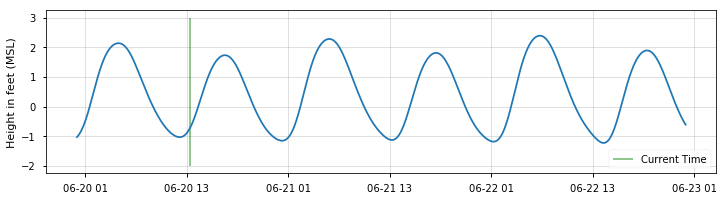

In [19]:
fig, ax = plt.subplots(1, figsize=(12, 3))
ax.plot(futuredaysLST, future_tide['h'])
ax.vlines(dt.today(), ymin=-2, ymax=3, color='g', alpha=0.5, label='Current Time')
ax.grid(alpha=0.4)
ax.set_ylabel('Height in feet (MSL)')
ax.legend(loc=4)

## Look at predictions vs. historical record

Reconstruct tides using calculated coefficients for the historical record

In [ ]:
tide = reconstruct(time, coef)

Calculate tidal residuals

In [ ]:
resid = obs['anomaly']-tide['h']
resid.describe()

Plot historic observations, hindcast tidal predictions, and residuals

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharey=True, sharex=True, figsize=(15, 6))

ax0.plot(obs.index, obs['anomaly'], label=u'Observations')
ax0.legend(numpoints=1, loc='lower right')

ax1.plot(obs.index, tide['h'], alpha=0.5, label=u'Prediction')
ax1.legend(numpoints=1, loc='lower right')

ax2.plot(obs.index, obs['anomaly']-tide['h'], alpha=0.5, label=u'Residue')
_ = ax2.legend(numpoints=1, loc='lower right')